# 复现Kaggle心脏病数据集冠军kernel


## Diagnosing Heart Disease
Using ML Explainability Tools and Techniques

### Contents
1. Introduction
2. The Data
3. The Model
4. The Explanation
5. Conclusion

### Introduction

In [34]:
#code from https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility
pd.options.mode.chained_assignment = None  #hide any pandas warnings

### The Data
Next, load the data,

In [117]:
dt = pd.read_csv("heart.csv")

In [118]:
dt.head(10)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   
5   57    1   0       140   192    0        1      148      0      0.4      1   
6   56    0   1       140   294    0        0      153      0      1.3      1   
7   44    1   1       120   263    0        1      173      0      0.0      2   
8   52    1   2       172   199    1        1      162      0      0.5      2   
9   57    1   2       150   168    0        1      174      0      1.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
5   0     1       1  
6   0     2       1  
7   0     3       1  
8   0     3       1  
9   0     2       1

Let's change the column names to be a bit clearer,

In [119]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [120]:
dt.head(10)

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   
5   57    1                0                     140          192   
6   56    0                1                     140          294   
7   44    1                1                     120          263   
8   52    1                2                     172          199   
9   57    1                2                     150          168   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    1         0                      150   
1                    0         1                      187   
2                    0         0                      172   
3                    0         1                      178   
4                    0         1                      163   
5                    0         1                      148   
6                    0         0                      153   
7                    0         1                      173   
8                    1         1                      162   
9                    0         1                      174   

   exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
0                        0            2.3         0                  0   
1                        0            3.5         0                  0   
2                        0            1.4         2                  0   
3                        0            0.8         2                  0   
4                        1            0.6         2                  0   
5                        0            0.4         1                  0   
6                        0            1.3         1                  0   
7                        0            0.0         2                  0   
8                        0            0.5         2                  0   
9                        0            1.6         2                  0   

   thalassemia  target  
0            1       1  
1            2       1  
2            2       1  
3            2       1  
4            2       1  
5            1       1  
6            2       1  
7            3       1  
8            3       1  
9            2       1

I'm also going to change the values of the categorical variables, to improve the interpretation later on,

In [121]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'
dt.head(10)

age     sex   chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    male  non-anginal pain                     145          233   
1   37    male   atypical angina                     130          250   
2   41  female    typical angina                     130          204   
3   56    male    typical angina                     120          236   
4   57  female                 0                     120          354   
5   57    male                 0                     140          192   
6   56  female    typical angina                     140          294   
7   44    male    typical angina                     120          263   
8   52    male   atypical angina                     172          199   
9   57    male   atypical angina                     150          168   

     fasting_blood_sugar               rest_ecg  max_heart_rate_achieved  \
0  greater than 120mg/ml                 normal                      150   
1    lower than 120mg/ml  ST-T wave abnormality                      187   
2    lower than 120mg/ml                 normal                      172   
3    lower than 120mg/ml  ST-T wave abnormality                      178   
4    lower than 120mg/ml  ST-T wave abnormality                      163   
5    lower than 120mg/ml  ST-T wave abnormality                      148   
6    lower than 120mg/ml                 normal                      153   
7    lower than 120mg/ml  ST-T wave abnormality                      173   
8  greater than 120mg/ml  ST-T wave abnormality                      162   
9    lower than 120mg/ml  ST-T wave abnormality                      174   

  exercise_induced_angina  st_depression   st_slope  num_major_vessels  \
0                      no            2.3          0                  0   
1                      no            3.5          0                  0   
2                      no            1.4       flat                  0   
3                      no            0.8       flat                  0   
4                     yes            0.6       flat                  0   
5                      no            0.4  upsloping                  0   
6                      no            1.3  upsloping                  0   
7                      no            0.0       flat                  0   
8                      no            0.5       flat                  0   
9                      no            1.6       flat                  0   

         thalassemia  target  
0             normal       1  
1       fixed defect       1  
2       fixed defect       1  
3       fixed defect       1  
4       fixed defect       1  
5             normal       1  
6       fixed defect       1  
7  reversable defect       1  
8  reversable defect       1  
9       fixed defect       1

In [122]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [123]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [124]:
dt = pd.get_dummies(dt, drop_first=True)

In [125]:
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  num_major_vessels  target  sex_male  \
0            2.3                  0       1         1   
1            3.5                  0       1         1   
2            1.4                  0       1         0   
3            0.8                  0       1         1   
4            0.6                  0       1         0   

   chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
0                                0                                 1   
1                                1                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
0                               0                                        0   
1                               0                                        1   
2                               1                                        1   
3                               1                                        1   
4                               0                                        1   

   rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
0                                      0                1   
1                                      0                0   
2                                      0                1   
3                                      0                0   
4                                      0                0   

   exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
0                            0              0                   0   
1                            0              0                   0   
2                            0              1                   0   
3                            0              1                   0   
4                            1              1                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0

Looking good. Now, on to the model.

### The Model
The next part fits a random forest model to the data,

In [126]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [127]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We can plot the consequent decision tree, to see what it's doing,

In [128]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [129]:
!pip3 install graphviz

In [130]:
#code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

This gives us on explainability tool. However, I can't glance at this and get a quick sense of the most important features. We'll revisit those later. Next, let's evaluate the model,

In [132]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

Assess the fit with a confusion matrix,

In [133]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[29,  6],
       [ 4, 22]], dtype=int64)

In [134]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8787878787878788
Specificity :  0.7857142857142857


That seems reasonable. Let's also check with a Receiver Operator Curve (ROC),

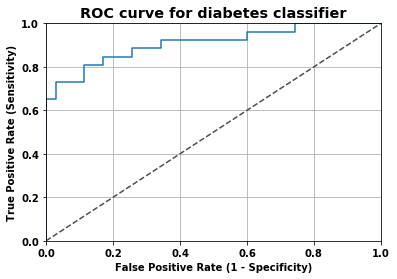

In [135]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

1. 0.90 - 1.00 = excellent
2. 0.80 - 0.90 = good
3. 0.70 - 0.80 = fair
4. 0.60 - 0.70 = poor
5. 0.50 - 0.60 = fail

Let's see what the above ROC gives us,

In [136]:
auc(fpr, tpr)

0.9076923076923078

### The Explanation
现在，让我们看看该模型从ML可解释性工具中给我们带来了什么。

排列重要性是了解机器学习模型的第一个工具，涉及将验证数据中的各个变量混排（在模型拟合后），并查看对准确性的影响。 在这里了解更多。

让我们来看看，

In [137]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

因此，就排列而言，最重要的因素似乎是“可逆缺陷”引起的地中海贫血的结果。 “达到最大心率”类型的高度重要性是有道理的，因为这是检查时患者的即刻主观状态（与年龄相比，这是更为普遍的因素）。

让我们使用部分依赖图来仔细研究主要血管的数量。 这些图在一行中跨一系列值改变单个变量，并查看其对结果的影响。 它针对多行执行此操作并绘制平均效果。 让我们看一下“ num_major_vessels”变量，它位于排列重要性列表的顶部，

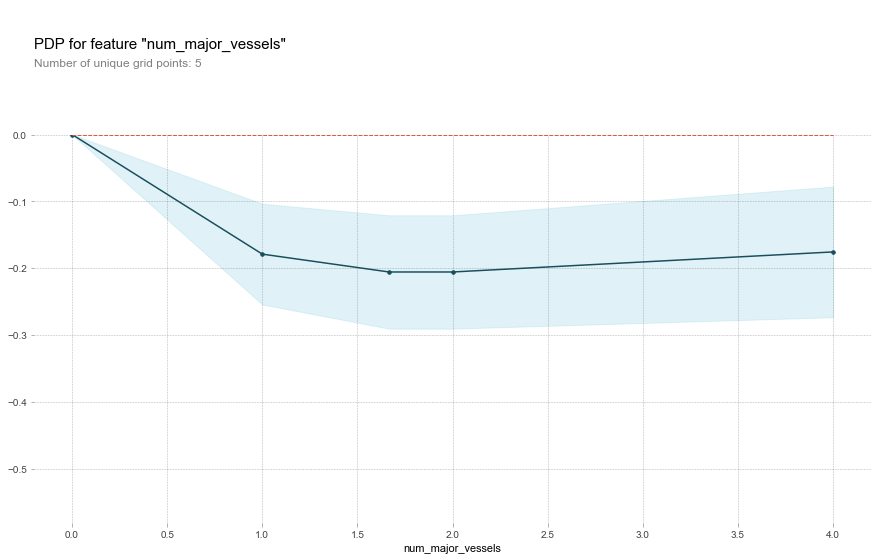

In [140]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

因此，我们可以看到，随着主要血管数量的增加，心脏病的可能性降低。 这是有道理的，因为这意味着更多的血液可以流入心脏。

那“年龄”呢？

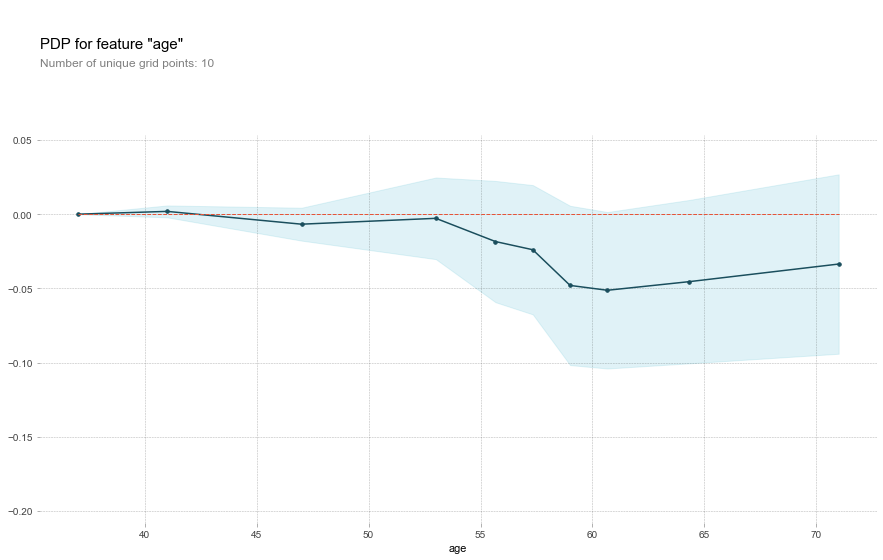

In [141]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

有点奇怪。 年龄越高，患心脏病的几率越低？ 尽管蓝色的置信度区域表明可能不正确（红色基线位于蓝色区域内）。

那“ st_depression”呢？

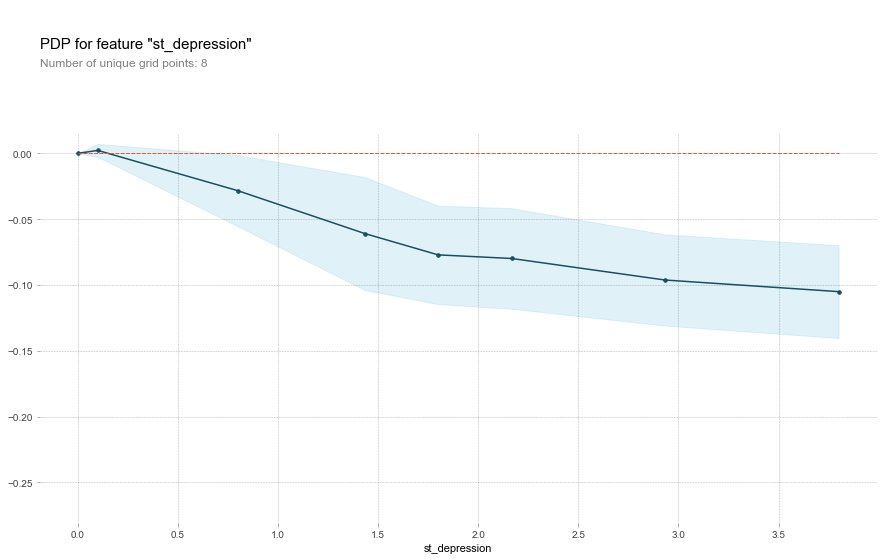

In [142]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

有趣的是，该变量越高，其概率也降低。这到底是什么？在Google上进行的搜索使我了解了内科医学专家Anthony L. Komaroff博士的以下描述：“心电图（ECG）可测量心脏的电活动。出现在心脏上的波被标记为P，QRS和T.每个部分对应心跳的不同部分，ST段代表左右心室收缩后立即将心脏的电活动，向肺和身体其余部分泵送血液。放松并为下一次收缩做好准备。在此期间，几乎没有电流流过，因此ST段处于基线水平，有时甚至略高于基线水平。 ST段的形状和方向远比其长度重要。向上或向下移动可能表示由于多种原因（包括心脏病发作，一个或多个冠状动脉痉挛（Prinzmetal的心绞痛），心脏内膜感染（心包炎）或心肌本身（心肌炎），血钾过多，心律问题或血栓形成肺（肺栓塞）。”

让我们看看SHAP值告诉我们什么。 这些方法通过显示一行中每个变量的值与其基线值相比的影响来工作。

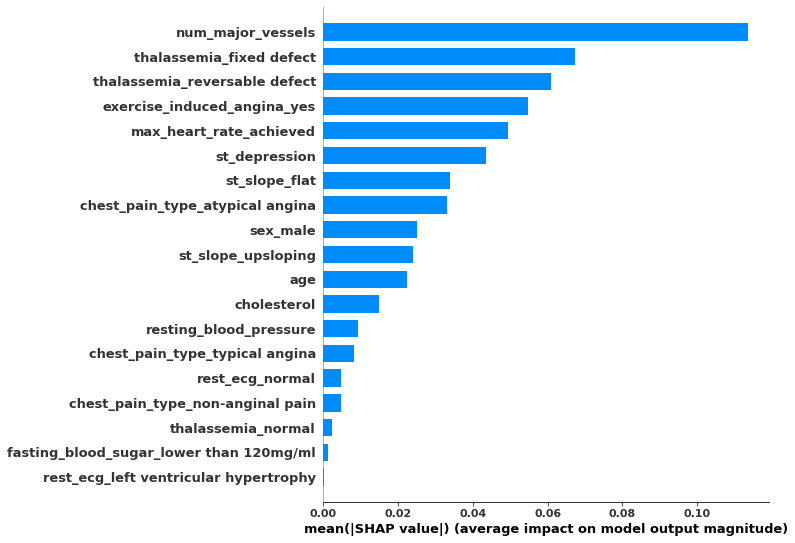

In [155]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

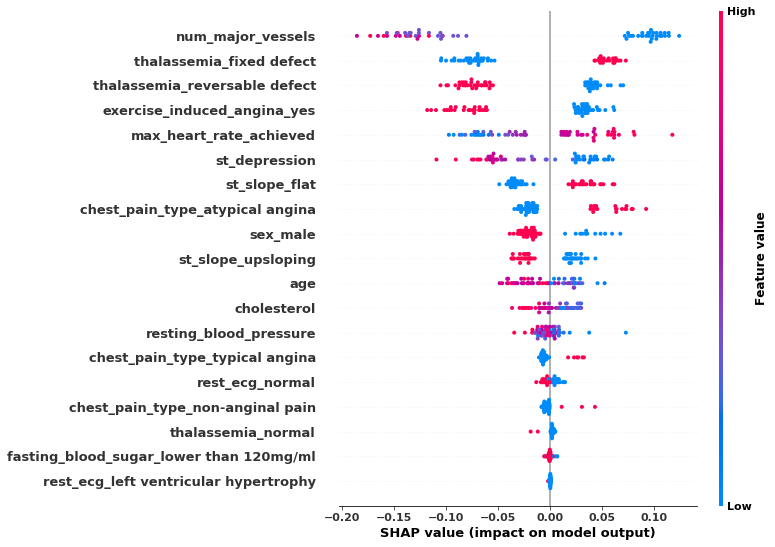

In [156]:
shap.summary_plot(shap_values[1], X_test)

In [157]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [158]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

对于这个人，预测是29％（基线为57％）。 许多特征对他们有利，包括有大血管，可逆性地中海贫血缺陷和没有平坦的斜面。

我们再来看看：

In [159]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

这个人，他们的预测是82％（基线为57％）。 

我们还可以绘制称为“ SHAP依赖关系贡献图”的内容，在SHAP值的背景下，这很容易解释，

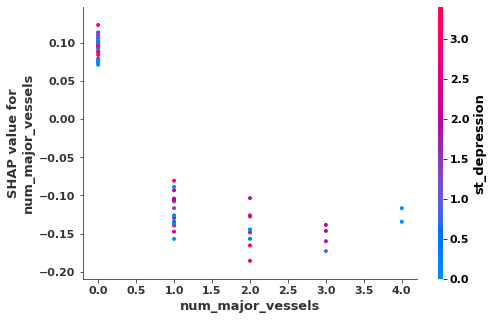

In [161]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

您可以看到对主要血管数量有明显的影响，但是颜色（st_depression）似乎并没有太大的作用。

对作者来说，最后的分析是最有效的分析之一。 它显示了许多（在本例中为50个）患者的预测和影响因素。 它也是交互式的。 悬停以查看为什么每个人最终变成红色（疾病预测）或蓝色（没有疾病预测），

In [162]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

### 结论
根据今天的标准，该数据集是少的又旧的。 但是，它允许我们创建一个简单的模型，然后使用各种机器学习可解释性工具和技术来窥视内部。首先，作者假设使用（Googled）领域知识来假设胆固醇和年龄等因素将是模型中的主要因素。该数据集没有显示出来。相反，主要因素和心电图结果的方面占主导。

作者认为随着机器学习在医疗保健中的作用越来越大，这种方法将变得越来越重要。